# Reinforcement Learning from Human Feedback Using PPO




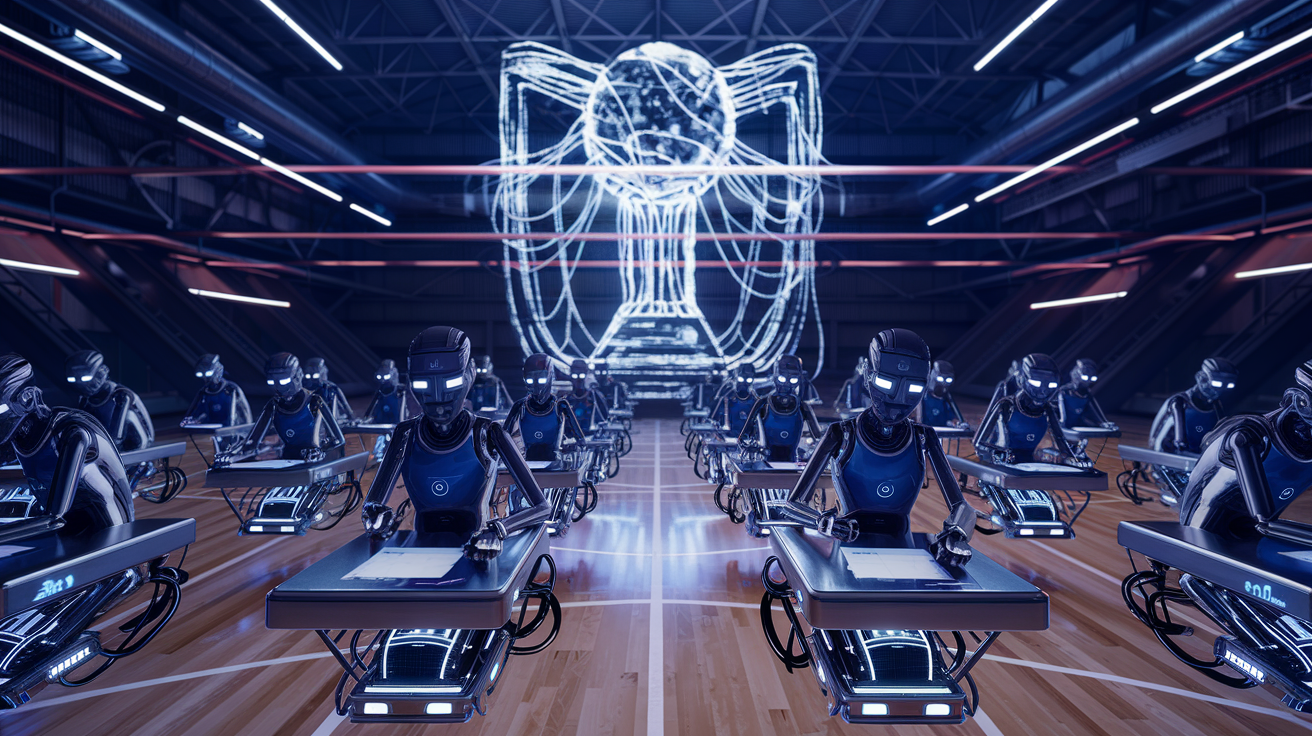

The above image is created using [ideogram.ai](https://ideogram.ai).


In this notebook we will create two types of LLMs to understand the topic: "Happy LLM" and a "Pessimistic LLM". To shape their responses, you use a reward function trained on a sentiment classifier from the IMDb dataset. Instead of traditional supervised learning, where the model learns from labeled data, you apply Reinforcement Learning (RL).

#### **What is RL?**
Reinforcement Learning is a type of machine learning where an agent (here, the LLM) learns by interacting with an environment (text generation) and receiving rewards or penalties based on its actions. The goal is to maximize rewards over time, improving decision-making through trial and error.

#### **Why PPO?**

Proximal Policy Optimization (PPO) is a powerful RL algorithm developed by OpenAI. It balances efficiency and stability, preventing extreme updates that could make training unstable. PPO is widely used in Reinforcement Learning from Human Feedback (RLHF), where human preferences fine-tune AI models to align with desired behaviors—like making an AI sound positive or negative in this case.

#### **What will you do?**

In this notebook, we fine-tune GPT-2 to generate positive movie reviews using the IMDb dataset. The model is given the beginning of a real review and learns to continue it in a positive tone. To guide this process, we use a BERT sentiment classifier to evaluate the generated text as a reward fuction. The BERT's classifier's sentiment scores serve as reward signals for PPO training, encouraging the model to produce more positive responses over time.


This notebook is based on [a Hugging Face example code titled "Tune GPT2 to generate positive reviews"](https://github.com/huggingface/trl/blob/main/examples/notebooks/gpt2-sentiment.ipynb).


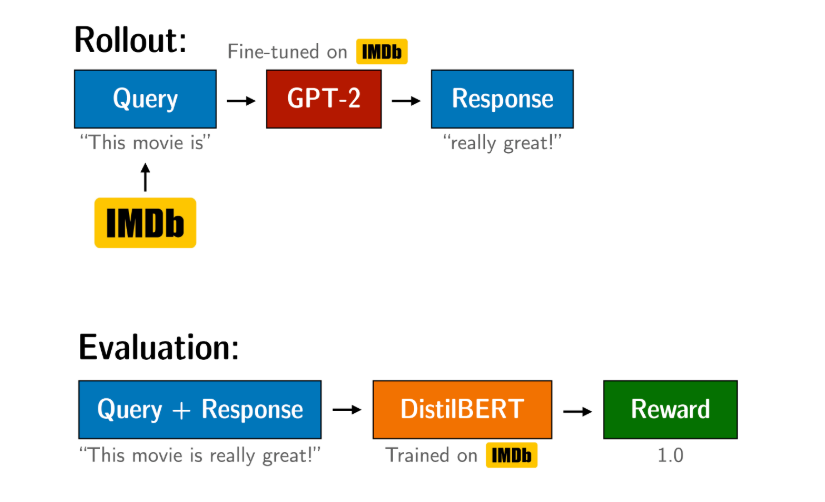

The above image is taken from [here](https://github.com/huggingface/trl/blob/main/examples/notebooks/gpt2-sentiment.ipynb).

## Objectives

- Learn about the basics of reinforcement learning and proximal policy optimization (PPO).
- Load the IMDb dataset for training.
- Implement the PPO agent and tokenizer (GPT2 model)
- Use a BERT classifier as a reward function.
- Create the PPO training loop.
- Generate text responses using the trained model loaded from Hugging Face.
- Compare the performance of reference model and fine-tuned model


----


### Installing required libraries



In [1]:
!pip install datasets
!pip install trl==0.9.6
!pip install transformers
!pip install nltk
!pip install rouge_score
!pip install matplotlib
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from tqdm import tqdm
import pandas as pd

tqdm.pandas()

from transformers import pipeline, AutoTokenizer,AutoModelForCausalLM
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler
import os

import tarfile
import pickle
import json
import matplotlib.pyplot as plt
import torch
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
# Disable warnings for a cleaner notebook or console experience
def warn(*args, **kwargs):
    pass
warnings.warn = warn

## Load the model, tokenizer and parameters

We will use the `PPOConfig` to arrange the configuration for the PPO training. The model name and learning rate (1.41e-5) is given to `PPOConfig`.
We will fine tune the GPT2 (`"lvwerra/gpt2-imdb"`) model. Recall that GPT2 model is pre-trained and fine-tuned on IMDB dataset for creating movie reviews.



In [4]:
config = PPOConfig(
    model_name="lvwerra/gpt2-imdb",
    learning_rate=1.41e-5)

# Define parameters for sentiment
sent_kwargs = {"top_k":None, "function_to_apply": "none", "batch_size": 2}

## Dataset

We will use the IMDB dataset that has 50,000 film reviews. The reviews are either POSITIVE or NEGATIVE.


In [5]:
dataset_name = "imdb"
dataset = load_dataset(dataset_name, split = "train")
dataset

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

Let's see an example data point in the IMDB dataset.

In [6]:
dataset[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [10]:
# Use a subset of the data since we use CPU
#dataset = dataset.select(range(100))
#len(dataset)

100

The `build_dataset` function below will handle all the preprocessing tasks for the dataset preparation. The explanations of each step is written inside the function.

In [13]:
def build_dataset(config, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8):

  # Initialize the tokenizer here again
  tokenizer = AutoTokenizer.from_pretrained(config.model_name)
  tokenizer.pad_token = tokenizer.eos_token
  # load the IMDB dataset
  ds = load_dataset(dataset_name, split="train")
  #Rename the column
  ds = ds.rename_columns({"text": "review"})
  # Get reviews whose length are > 200
  ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

  # Use LengthSampler to create various text lengths to make the model more robust and
  # capable of handling varying input lengths for better generalization.
  # The sample length differs between input_min_text_length and input_max_text_length
  input_size = LengthSampler(input_min_text_length, input_max_text_length)

  # Tokenizer
  def tokenize(sample):
      # Encode the reviews
      sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
      #
      sample["query"] = tokenizer.decode(sample["input_ids"])
      return sample

  ds = ds.map(tokenize, batched=False)
  ds.set_format(type="torch")
  return ds

# Build the dataset
dataset = build_dataset(config)

tokenizer_config.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24895 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1168 > 1024). Running this sequence through the model will result in indexing errors


## Collator function
We then dfine the collator function which is important in PPO training. It prepare data batches in a format suitable for the PPOTrainer.

In [15]:
def collator(data):
    return {key: [item[key] for item in data] for key in data[0]}

Let's create an example to understand how collator function works.


In [16]:
data = [
    {'input_ids': [1, 2, 3, 4], 'query': "query 1", 'review': "review 1"},
    {'input_ids': [5, 6, 7, 8], 'query': "query 2", 'review': "review 2"}
]

# Call the function
batch = collator(data)
batch

{'input_ids': [[1, 2, 3, 4], [5, 6, 7, 8]],
 'query': ['query 1', 'query 2'],
 'review': ['review 1', 'review 2']}

## Load the models and tokenizer

We will use the `AutoModelForCausalLMWithValueHead` to load the GPT-2 for PPO training. During the PPO training we will update this model's parameters and fine-tune to generate POSITIVE responses.
Then we define the tokenizer and set the tokenizer's end of sequence (EOS) token.

In [17]:
# Define the model
model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)

# Define the tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.model_name)

# Set the EOS token
tokenizer.pad_token = tokenizer.eos_token

pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Also we define a reference model to use in PPO training. The reference model will regularize the output's of the GPT2 model using Kullback-Leibler (KL) divergence. The KL divergence measures the difference between two data distributions, in our case it will measure the difference between GPT2's output sequence and reference model's output sequence and make sure that optimized model will not diverge too much from the reference model.




In [18]:
# Define the reference model
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)

##  Initialize PPOTrainer

Proximal Policy Optimization (PPO) is a reinforcement learning approach designed for training generative models, particularly those used in chatbots. It effectively tackles challenges such as ensuring dialogues remain coherent and contextually relevant.

PPO enhances policy gradient techniques by incorporating a clipped objective function, which promotes gradual and stable updates to the policy. This approach helps maintain consistency in chatbot interactions.

The PPO Trainer is responsible for gathering dialogue samples, refining the chatbot’s policy based on these interactions, and managing the underlying neural network models. This structured training process results in improved stability, efficiency, and overall response quality.



In [19]:
# Parameters
# config : Configuration settings(learning rate and model name)
# model: The primary model to be fine-tuned using PPO.
# tokenizer: Tokenizer for processing input
# dataset
# data_collator: Data collator to handle batching and formatting of the input data

ppo_trainer = PPOTrainer(config, model, ref_model, tokenizer, dataset=dataset, data_collator=collator)


Determine the appropriate device (CPU or GPU) for training with the PPO Trainer.





In [20]:
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Reward function

In reinforcement learning using Proximal Policy Optimization (PPO), a reward function plays a crucial role in assessing the effectiveness of the actions taken by the policy. When applied to a generative model like a chatbot, this function helps evaluate the quality of generated responses.

A sentiment analysis pipeline can be utilized as a reward function in PPO-based training. By analyzing the sentiment of each chatbot response and assigning rewards accordingly, the PPO Trainer refines the chatbot’s policy to produce more engaging and positively received interactions. This method provides meaningful feedback, guiding the chatbot towards generating higher-quality dialogue.

The reward model is chosen as the pretrained BERT classifier fine-tuned on the IMDB dataset. It determines how much a sentence is POSITIVE or NEGATIVE by assigning a score.

In [21]:
# Define the reward model (BERT classifier)
reward_pipeline = pipeline("sentiment-analysis", model="lvwerra/distilbert-imdb", device=device)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


Let's see some examples


In [22]:
text = "OMG I love this movie!!!"
reward_pipeline(text, **sent_kwargs)


[{'label': 'POSITIVE', 'score': 2.7417538166046143},
 {'label': 'NEGATIVE', 'score': -2.458040952682495}]

The score key reflects the model's confidence in its predictions. Higher values indicate stronger certainty in classifying sentiment as either "POSITIVE" or "NEGATIVE." We will use this score as reward values in reinforcement learning.
 Essentially, positive sentiment increases the overall reward, while negative sentiment decreases it.


In [23]:
text = "So boring :(("
reward_pipeline(text, **sent_kwargs)

[{'label': 'NEGATIVE', 'score': 1.799544334411621},
 {'label': 'POSITIVE', 'score': -2.216062307357788}]

## Training

Explanation of PPO Training steps:

1. Extract Query Tensors:

The input IDs, also known as query tensors, are retrieved from the batch.

2. Generate Responses:

Using the ppo_trainer.generate method with predefined generation_kwargs, a response is generated for each query tensor.
The generated responses are then decoded and added to the batch under the response key.

3. Compute Sentiment Scores (rewards):

The text data is formatted by concatenating queries with their respective responses.
Sentiment analysis is applied to the combined text to calculate sentiment scores.
These scores are transformed into tensors and stored in the rewards list.

4. Execute PPO Update Step:

The ppo_trainer.step function updates the model usinng 3 parameters (query_tensors, response_tensors, rewards).

This step calculates policy and value function losses, computes gradients, and adjusts the policy network parameters.
The update process ensures policy changes remain within a controlled range to prevent drastic shifts.

5. Log Training Statistics:

Key metrics and statistics from the PPO training step are recorded and stored in the all_stats list for further analysis.


In [70]:
# Define parameters for pop trainer
generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

In [71]:
# Define the output length range as [4-16]
output_min_length = 4
output_max_length = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)

In [72]:
# Training loop

for epoch, batch in enumerate(tqdm(ppo_trainer.dataloader)):
    query_tensors = batch["input_ids"]

    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        # Generate response
        query_response = ppo_trainer.generate(query, **generation_kwargs).squeeze()
        response_len = len(query_response) - len(query)
        response_tensors.append(query_response[-response_len:])
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    #### Compute sentiment score (reward) using BERT classifier
    # Note that we concat query and response to feed the BERT
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = reward_pipeline(texts, **sent_kwargs)
    positive_scores = [
        item["score"]
        for output in pipe_outputs
        for item in output
        if item["label"] == "POSITIVE"
    ]
    rewards = [torch.tensor(score) for score in positive_scores]

    #### Run PPO step
    #  The PPO step computes the gradients and updates the model with (query_tensors, response_tensors, and rewards)
    # It assures that the policy update stays within a certain range to avoid creating unrelevant response.
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    # Save the PPO statistics
    ppo_trainer.log_stats(stats, batch, rewards)

  0%|          | 0/194 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [72]:
# # Save the model

# model_dir = "xxx"
# os.makedirs(model_dir, exist_ok=True)

# # Save model configuration and weights
# model.save_pretrained(model_dir)
# tokenizer.save_pretrained(model_dir)

Since training takes too much time and we are using CPU, we will not train the model. Instead we will load the trained model from Hugging Face. You can find the link [here](https://huggingface.co/eurus7/gpt2-imdb-pos-v2).

In [28]:
from transformers import AutoTokenizer
from trl import AutoModelForCausalLMWithValueHead

# Load the model from Hugging Face
tokenizer = AutoTokenizer.from_pretrained("eurus7/gpt2-imdb-pos-v2")
# Load the tokenizer
loaded_model = AutoModelForCausalLMWithValueHead.from_pretrained("eurus7/gpt2-imdb-pos-v2")
loaded_model.to(device)

# Arrange setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Arrange generation parameters
gen_kwargs = {"min_length": -1, "max_new_tokens":20, "top_k": 0.0, "top_p": 1.0, "do_sample": True, "pad_token_id": tokenizer.eos_token_id}

# Below function takes a query and a model and generates response
def generate_some_text(input_text,my_model):
    # Tokenize the input text
    input_ids = tokenizer(input_text, return_tensors='pt').input_ids.to(device)
    #Generate response
    generated_ids = my_model.generate(input_ids,**gen_kwargs )

    # Decode the generated text
    generated_text_ = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return generated_text_

#####################################
## Now let's test the loaded model.
input_text = "Once upon a time in a land far"

generated_text=generate_some_text(input_text, loaded_model)
generated_text

'Once upon a time in a land far more authentic, Eternal Sunshine is superb; its beautiful imperfections are complemented with attitude, tender heart'

## Model inspection

Let's analyse some examples from the IMDB dataset. We can use ref_model to compare the fine-tuned model (defined as `model`) against the model before optimisation.

In [29]:
# Define the output length range as [4-16]
output_min_length = 4
output_max_length = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)

In [31]:
# Define parameters for pop trainer
generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

In [32]:
#### get a batch from the dataset
bs = 16
game_data = dict()
dataset.set_format("pandas")
df_batch = dataset[:].sample(bs)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

response_tensors_ref, response_tensors = [], []

#### get response from gpt2 and gpt2_ref
for i in range(bs):
    query = torch.tensor(query_tensors[i]).to(device)

    gen_len = output_length_sampler()
    # Get response from the ref_model
    query_response = ref_model.generate( query.unsqueeze(0), max_new_tokens=gen_len, **generation_kwargs).squeeze()
    response_len = len(query_response) - len(query)
    response_tensors_ref.append(query_response[-response_len:])

    # Get response from the loaded model
    query_response = loaded_model.generate(query.unsqueeze(0), max_new_tokens=gen_len, **generation_kwargs).squeeze()
    response_len = len(query_response) - len(query)
    response_tensors.append(query_response[-response_len:])

#### decode responses
game_data["response (before)"] = [tokenizer.decode(response_tensors_ref[i]) for i in range(bs)]
game_data["response (after)"] = [tokenizer.decode(response_tensors[i]) for i in range(bs)]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
pipe_outputs = reward_pipeline(texts, **sent_kwargs)
positive_scores = [item["score"] for output in pipe_outputs for item in output if item["label"] == "POSITIVE"]
game_data["rewards (before)"] = positive_scores

texts = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
pipe_outputs = reward_pipeline(texts, **sent_kwargs)
positive_scores = [ item["score"] for output in pipe_outputs for item in output if item["label"] == "POSITIVE"]
game_data["rewards (after)"] = positive_scores

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

,query,response (before),response (after),rewards (before),rewards (after)
0,...when he rem,ade Santa Claus...! He draws pictures for the ...,ade the series I have a wonderful album and it...,1.401897,2.880011
1,As other viewers,"said the movie was a farce, I couldn't speak or","will note, the film explores many paths, from...",-1.829627,2.544024
2,"First,",this movie seemed like it could easily have b...,the movie is well acted. The photography here...,-2.573679,2.471249
3,Although well,actually it certainly could not be made in th...,"done, this is a delightful Hollywood film, wi...",-0.745664,2.868567
4,This is a fascinating film--,influenced by Poe but,it gives a splendid intimacy to,2.525360,2.904292
5,When watching,this film you'll swear that you know what it was,"this has impressed me, it is truly a well-",0.439585,2.832706
6,Walter Pidgeon,'s crazy streak animating the movie is complet...,is this excellent action gem. The flow of scene,-2.252852,2.885359
7,Richard Tyler is a little boy,who is held prisoner in a concentration camp,who has told the story of love.,0.209513,1.882964
8,Oh dear. While,this movie is Po-Go and I usually like the mo...,"it holds up excellent, my favourite was this ...",0.621395,2.617628
9,"""Magic"" isn't too","good, but see it if you need a laugh.<|endoft...","abstract, and the inspiration behind this bea...",0.627576,2.818628
